In [1]:
import numpy as np
import cv2
import os
import random
import glob
from tqdm import tqdm 
import natsort
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

import matplotlib.pylab as plt
import warnings
warnings.filterwarnings("ignore")

In [2]:
import rioxarray as xr
import rasterio
import tifffile

from rasterio.plot import show
from early_stopping import EarlyStopping
from utils import DiceLoss

In [3]:
import torch 
from torchvision import transforms

from torch import nn
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import ToTensor
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

import segmentation_models_pytorch as smp

In [4]:
CFG = {
    'RESIZE_WIDTH':32,
    'RESIZE_HEIGHT':32,
    'EPOCHS':50,
    'LEARNING_RATE':3e-4,
    'BATCH_SIZE':8,
    'SEED':41,
}

In [5]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(CFG['SEED']) # Seed 고정

In [6]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [7]:
train_path =  './train/s2_image/'
mask_path = './train/mask/'

masks = glob.glob(f'{mask_path}/*')
trains = glob.glob(f'{train_path}/*')
masks.sort()
trains.sort()

In [8]:
total_df = pd.DataFrame({'img_path': trains, 'mask_path': masks})

In [9]:
# total_df = total_df.iloc[:1000]

In [10]:
X_train, X_valid= train_test_split(total_df, test_size=0.2, random_state=CFG['SEED'])
X_train = X_train.reset_index(drop=True)
X_valid = X_valid.reset_index(drop=True)
print(X_train.shape, X_valid.shape)

(1652, 2) (414, 2)


In [11]:
class CustomDataset(Dataset):
    def __init__(self, df, train_mode=True, transforms=None):
        self.image_list = df['img_path'].to_list()
        self.mask_list = df['mask_path'].to_list()
        self.train_mode = train_mode
        self.transforms = transforms

    def load_image_and_mask(self, img_dir, mask_dir):
        img = tifffile.imread(img_dir).astype(np.float64)
        img = cv2.resize(img, (CFG['RESIZE_WIDTH'], CFG['RESIZE_HEIGHT']))
        img = np.transpose(img, (2, 0, 1))
        img = torch.FloatTensor(img)

        mask = tifffile.imread(mask_dir).astype(np.float64)
        mask = cv2.resize(mask, (CFG['RESIZE_WIDTH'], CFG['RESIZE_HEIGHT']))
        mask = np.reshape(mask, (1, *mask.shape))
        mask = torch.FloatTensor(mask)

        return img, mask

    def __getitem__(self, index):
        X_feature, label = self.load_image_and_mask(self.image_list[index], self.mask_list[index])

        if self.transforms is not None:
            X_feature = self.transforms(X_feature)

        if self.train_mode:
            return X_feature, label
        else:
            return X_feature

    def __len__(self):
        return len(self.image_list)


In [12]:
train_dataset = CustomDataset(X_train, train_mode=True)
train_loader = DataLoader(train_dataset, batch_size = CFG['BATCH_SIZE'], shuffle=True)

vali_dataset = CustomDataset(X_valid, train_mode=True)
vali_loader = DataLoader(vali_dataset, batch_size = CFG['BATCH_SIZE'], shuffle=False)

In [13]:
print(vali_dataset[0][0].shape)
print(np.unique(vali_dataset[0][0]))

torch.Size([12, 32, 32])
[ 181.83063  182.00406  196.16324 ... 3509.7744  3524.8945  3525.427  ]


In [14]:
print(vali_dataset[0][1].shape)
print(np.unique(vali_dataset[0][1]))

torch.Size([1, 32, 32])
[0.         0.01098633 0.01538086 0.02075195 0.02270508 0.04125977
 0.04467773 0.04516602 0.046875   0.07299805 0.0769043  0.078125
 0.09838867 0.11352539 0.1237793  0.12866211 0.13647461 0.15014648
 0.17944336 0.18725586 0.203125   0.21166992 0.234375   0.24975586
 0.2512207  0.2800293  0.29516602 0.31030273 0.33129883 0.3708496
 0.38134766 0.39038086 0.4465332  0.46069336 0.46166992 0.47680664
 0.484375   0.515625   0.5617676  0.5834961  0.6052246  0.609375
 0.6105957  0.61938477 0.640625   0.65356445 0.6574707  0.7297363
 0.765625   0.7697754  0.7844238  0.796875   0.82592773 0.8498535
 0.8820801  0.9157715  0.921875   0.953125   0.9758301  1.        ]


In [19]:
seg_model = smp.FPN(
    encoder_name="efficientnet-b7",        # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
    # use `imagenet` pre-trained weights for encoder initialization
    # encoder_weights="imagenet",
    # model input channels (1 for gray-scale images, 3 for RGB, etc.)
    in_channels=12, #(img 3, mask 3) -> 
    # model output channels (number of classes in your dataset)
    classes=1,
    activation='sigmoid' # could be None for logits or 'softmax2d' for multiclass segmentation
)

In [20]:
# criterion = nn.BCELoss().to(device)
criterion = DiceLoss().to(device)
optimizer = torch.optim.Adam(params=seg_model.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3,threshold_mode='abs',min_lr=1e-8, verbose=True)

In [21]:
def validation(model, criterion, val_loader, device):
    model.eval()
    val_loss = []

    with torch.no_grad():
        for img, label in tqdm(iter(val_loader)):
            img, label = img.float().to(device), label.to(device)
            logit = model(img)
            loss = criterion(logit, label)
            val_loss.append(loss.item())
        _val_loss = np.mean(val_loss)
        
    return _val_loss

In [22]:
from tqdm.auto import tqdm

def train(model, optimizer, train_loader, scheduler, device): 
    model.to(device)
    total_train_loss, total_valid_loss = [],[]

    patience = 5
    early_stopping = EarlyStopping(patience = patience, path = f'./weights/best.pt', verbose = True)

    for epoch in range(1, CFG['EPOCHS']):  # Adjusted to include the last epoch
        model.train()
        train_loss = []

        for img, label in tqdm(iter(train_loader)):
            img, label = img.float().to(device), label.to(device)
            optimizer.zero_grad()
            logit = model(img)
            loss = criterion(logit, label)
            loss.backward()
            optimizer.step()
            train_loss.append(loss.item())

        _train_loss = np.mean(train_loss)
        _val_loss = validation(model, criterion, vali_loader, device)

        total_train_loss.append(_train_loss)
        total_valid_loss.append(_val_loss)

        print(f'Epoch [{epoch}], Train Loss : [{_train_loss:.5f}] Val Loss : [{_val_loss:.5f}]')

        if scheduler is not None:
            scheduler.step(_val_loss)

        early_stopping(_val_loss, model)
        if early_stopping.early_stop:
            print("Early stopping")
            break

    return total_train_loss, total_valid_loss

In [23]:
total_train_loss, total_valid_loss= train(seg_model, optimizer, train_loader, scheduler, device)

  0%|          | 0/207 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

Epoch [1], Train Loss : [0.47875] Val Loss : [0.36948]
Validation loss decreased (inf --> 0.369482).  Saving model ...


  0%|          | 0/207 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

Epoch [2], Train Loss : [0.37670] Val Loss : [0.34760]
Validation loss decreased (0.369482 --> 0.347604).  Saving model ...


  0%|          | 0/207 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

Epoch [3], Train Loss : [0.33308] Val Loss : [0.32807]
Validation loss decreased (0.347604 --> 0.328072).  Saving model ...


  0%|          | 0/207 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

Epoch [4], Train Loss : [0.34944] Val Loss : [0.42268]
EarlyStopping counter: 1 out of 5


  0%|          | 0/207 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

Epoch [5], Train Loss : [0.35998] Val Loss : [0.48014]
EarlyStopping counter: 2 out of 5


  0%|          | 0/207 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

Epoch [6], Train Loss : [0.32623] Val Loss : [0.50007]
EarlyStopping counter: 3 out of 5


  0%|          | 0/207 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

Epoch [7], Train Loss : [0.33407] Val Loss : [0.32255]
Validation loss decreased (0.328072 --> 0.322548).  Saving model ...


  0%|          | 0/207 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

Epoch [8], Train Loss : [0.30582] Val Loss : [0.35108]
EarlyStopping counter: 1 out of 5


  0%|          | 0/207 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

Epoch [9], Train Loss : [0.31067] Val Loss : [0.30994]
Validation loss decreased (0.322548 --> 0.309942).  Saving model ...


  0%|          | 0/207 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

Epoch [10], Train Loss : [0.30197] Val Loss : [0.32565]
EarlyStopping counter: 1 out of 5


  0%|          | 0/207 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

Epoch [11], Train Loss : [0.27943] Val Loss : [0.30966]
Validation loss decreased (0.309942 --> 0.309664).  Saving model ...


  0%|          | 0/207 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

Epoch [12], Train Loss : [0.29456] Val Loss : [0.40703]
EarlyStopping counter: 1 out of 5


  0%|          | 0/207 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

Epoch [13], Train Loss : [0.30146] Val Loss : [0.30420]
Validation loss decreased (0.309664 --> 0.304197).  Saving model ...


  0%|          | 0/207 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

Epoch [14], Train Loss : [0.29233] Val Loss : [0.36370]
EarlyStopping counter: 1 out of 5


  0%|          | 0/207 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

Epoch [15], Train Loss : [0.28819] Val Loss : [0.33558]
EarlyStopping counter: 2 out of 5


  0%|          | 0/207 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

Epoch [16], Train Loss : [0.28436] Val Loss : [0.30200]
Validation loss decreased (0.304197 --> 0.302002).  Saving model ...


  0%|          | 0/207 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

Epoch [17], Train Loss : [0.28385] Val Loss : [0.32718]
EarlyStopping counter: 1 out of 5


  0%|          | 0/207 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

Epoch [18], Train Loss : [0.27326] Val Loss : [0.29654]
Validation loss decreased (0.302002 --> 0.296541).  Saving model ...


  0%|          | 0/207 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

Epoch [19], Train Loss : [0.26167] Val Loss : [0.30315]
EarlyStopping counter: 1 out of 5


  0%|          | 0/207 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

Epoch [20], Train Loss : [0.25752] Val Loss : [0.31370]
EarlyStopping counter: 2 out of 5


  0%|          | 0/207 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

Epoch [21], Train Loss : [0.25110] Val Loss : [0.29613]
Validation loss decreased (0.296541 --> 0.296130).  Saving model ...


  0%|          | 0/207 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

Epoch [22], Train Loss : [0.24481] Val Loss : [0.29450]
Validation loss decreased (0.296130 --> 0.294497).  Saving model ...


  0%|          | 0/207 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

Epoch [23], Train Loss : [0.25501] Val Loss : [0.30702]
EarlyStopping counter: 1 out of 5


  0%|          | 0/207 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

Epoch [24], Train Loss : [0.25577] Val Loss : [0.41528]
EarlyStopping counter: 2 out of 5


  0%|          | 0/207 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

Epoch [25], Train Loss : [0.28443] Val Loss : [0.28946]
Validation loss decreased (0.294497 --> 0.289460).  Saving model ...


  0%|          | 0/207 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

Epoch [26], Train Loss : [0.26583] Val Loss : [0.30370]
EarlyStopping counter: 1 out of 5


  0%|          | 0/207 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

Epoch [27], Train Loss : [0.25931] Val Loss : [0.29200]
EarlyStopping counter: 2 out of 5


  0%|          | 0/207 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

Epoch [28], Train Loss : [0.25687] Val Loss : [0.30588]
EarlyStopping counter: 3 out of 5


  0%|          | 0/207 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

Epoch [29], Train Loss : [0.24662] Val Loss : [0.30460]
Epoch 00029: reducing learning rate of group 0 to 5.0000e-04.
EarlyStopping counter: 4 out of 5


  0%|          | 0/207 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

Epoch [30], Train Loss : [0.24895] Val Loss : [0.29960]
EarlyStopping counter: 5 out of 5
Early stopping


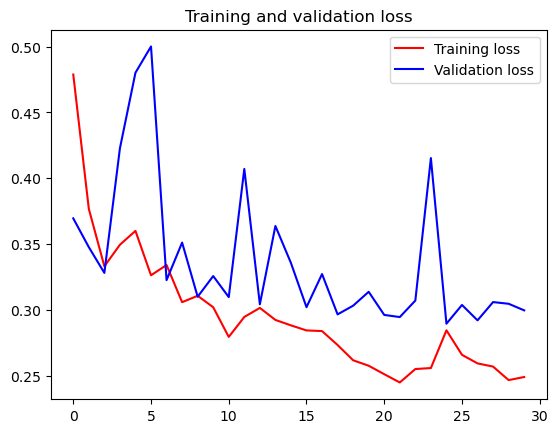

In [24]:
epochs = range(len(total_train_loss))

plt.plot(epochs, total_train_loss, 'r', label='Training loss')
plt.plot(epochs, total_valid_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
 
plt.show()

In [25]:
test_path =  './evaluation/'
test_mask_path = './sample/'

masks = glob.glob(f'{test_mask_path}/*')
tests = glob.glob(f'{test_path}/*')
masks.sort()
tests.sort()

In [26]:
import os
if not os.path.isdir('output_dl'):
    os.mkdir('output_dl')

In [27]:
total_test_df = pd.DataFrame({'img_path': tests, 'mask_path': masks})

In [28]:
test_dataset = CustomDataset(total_test_df, train_mode=False)
test_loader = DataLoader(test_dataset, batch_size = 1, shuffle=False)

In [44]:
def test(test_loader):
    ckpt = torch.load('./weights/best.pt')
    seg_model.load_state_dict(ckpt)
    seg_model.eval()
    seg_model.cuda()

    with torch.no_grad():
        pred_mask_list=[]
        for idx, images in tqdm(enumerate(test_loader)):
            basename = os.path.basename(total_test_df['mask_path'].iloc[idx])
            output_file = f'output_dl/{basename}'

            m = total_test_df['mask_path'].iloc[idx]
            masks = tifffile.imread(m).astype(np.float64)
            shape_mask = masks.shape

            images = images.float().to(device)
            outputs = seg_model(images)
            outputs = outputs.detach().cpu().numpy()
            outputs = np.squeeze(outputs, 0)

            pred_mask = np.transpose(outputs, (1,2,0)) #(32, 32, 1)
            pred_mask = cv2.resize(pred_mask,(shape_mask[0],shape_mask[1]),interpolation=cv2.INTER_NEAREST) #(23, 23)
            
            pred_mask = (pred_mask > 0.5).astype(np.uint8)
            pred_mask = np.reshape(pred_mask, (shape_mask[0],shape_mask[1], 1)) #(23,23,1)

            # pred_mask = np.argmax(pred_mask, axis=2).astype(np.uint8)
            pred_mask_list.append(pred_mask)
            tifffile.imwrite(output_file, pred_mask)

    return pred_mask_list

In [45]:
pred_mask_list = test(test_loader)

0it [00:00, ?it/s]

In [42]:
# import matplotlib.pyplot as plt
# for i in range(len(pred_mask_list)):
#     plt.imshow(pred_mask_list[i])
#     plt.show()

In [46]:
import zipfile

output_folder_path = 'output_dl'
with zipfile.ZipFile('output_zip_1019_dl(1).zip', 'w') as zipf:
    for root, dirs, files in os.walk(output_folder_path):
        for file in files:
            zipf.write(os.path.join(root, file), file)

In [149]:
# m = total_test_df['img_path'].iloc[idx]
# masks = tifffile.imread(m).astype(np.float64)
# shape_mask = masks.shape